In [35]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy
import math

import torch
from transformers import pipeline
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("We would be using this device:", device)

We would be using this device: cuda


# Loading Datasets

we have loaded the datasets using the hugging face's datasets library, we have observed the TL-DR Datasets split already done into train, test and validation

In [2]:
data_set = load_dataset("trl-lib/tldr")
ds = data_set

In [3]:
train_set = pd.DataFrame(ds["train"])
print(ds.keys())

dict_keys(['train', 'validation', 'test'])


In [4]:
train_size, validation_size, test_size = ds["train"].shape[0], ds["validation"].shape[0], ds["test"].shape[0]
toto = train_size + validation_size + test_size

print("Training Set Size: ", "{:.2f}".format(train_size / toto * 1e2), "%",  " With Records: ", train_size,sep="")
print("Test Set Size: ", "{:.2f}".format(test_size / toto * 1e2), "%",  " With Records: ", test_size,sep="")
print("Validation Set Size: ", "{:.2f}".format(validation_size / toto * 1e2), "%", " With Records: ", validation_size, sep="")

Training Set Size: 89.98% With Records: 116722
Test Set Size: 5.05% With Records: 6553
Validation Set Size: 4.97% With Records: 6447


In [5]:
record = train_set.sample(random_state=56)

In [6]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

In [7]:
print(record.completion.values[0])

 Parking pass registered for 2 vehicles was left at home.  Appeal was denied, nobody has responded. Fee increases tomorrow.


## Preprocessing Task

We wanted to have post and its title and content seperately so we wanted to extract them out first

1. Extract Title
2. Extract Post

We have decided to keep the text as human written as possible

## Extract Title - using Regex

we would be using Regex for extracting the title out of the Reddit Post

In [8]:
print(record.prompt.str.extract(r'TITLE: ((.|\n)*)\n\nPOST:').values[0][0])

Is my school extorting me?


## Extract Post - using Regex

likewise we would be using the Regex for extracting the Post content out of the Reddit Post

In [9]:
print(record.prompt.str.extract(r'POST: ((.|\n)*)\nTL;DR:', expand=False).values[0][0])

I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I can't afford to pay the extra $15.  If I don't pay the ticket at 

In [10]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

## Extracting the Title and the Post from the dataset into seperate columns.

Convert the Dataset to Data Frame and then add columns for post and title

In [36]:
ds = {}
for set_type in data_set.keys():
  ds[set_type] = pd.DataFrame(data_set[set_type])
  ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
      r'POST: ((.|\n)*)\nTL;DR:', expand=False
  ).iloc[:, 0]
  ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
    r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
  ).iloc[:, 0]
  ds[set_type]["subreddit"] = ds[set_type].prompt.str.extract(
    r'SUBREDDIT: ((.|\n)*)\n\nTITLE:', expand=False
  ).iloc[:, 0]


In [37]:
train_set = ds["train"]
print(train_set.iloc[0, :])

prompt          SUBREDDIT: r/relationships\n\nTITLE: I (f/22) ...
completion       I still have contact with an old ex's friends...
prompt_post     Not sure if this belongs here but it's worth a...
prompt_title    I (f/22) have to figure out if I want to still...
subreddit                                         r/relationships
Name: 0, dtype: object


# Do some basic statistics on the Train set

* Extract the Number of Words in the Prompt
* Extract the Number of Words in the Completion Text
* Extract the Number of Words in the Title


and see if there's any pattern between them

In [15]:
n_words_prompt = []
n_words_completion = []
n_words_title = []
for prompt, completion, title in zip(train_set.prompt, train_set.completion, train_set.prompt_title):
  n_words_prompt.append(len(prompt.split()))
  n_words_completion.append(len(completion.split()))
  n_words_title.append(len(title.split()))

counts = pd.DataFrame(
    {
        "prompt": n_words_prompt,
        "completion": n_words_completion,
        "title": n_words_title,
    }
)


In [16]:
for (task, _counts) in ((
    ("Prompt", n_words_prompt),
    ("Prompt's Completion", n_words_completion),
    ("Prompt's Title", n_words_title),
)):
    stats = scipy.stats.describe(_counts)
    print("Stats for the", task, ":", stats)
    print("STD:", math.sqrt(stats.variance))
    print()

Stats for the Prompt : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(11), np.int64(442)), mean=np.float64(266.40081561316634), variance=np.float64(6029.432066572026), skewness=np.float64(-0.06594287659561676), kurtosis=np.float64(-0.863107830526471))
STD: 77.64941768340589

Stats for the Prompt's Completion : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(7), np.int64(47)), mean=np.float64(27.02162402974589), variance=np.float64(34.70547220250788), skewness=np.float64(0.48083771190937125), kurtosis=np.float64(-0.4477978319286593))
STD: 5.891135052136208

Stats for the Prompt's Title : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(1), np.int64(64)), mean=np.float64(15.78543033875362), variance=np.float64(60.80944391184177), skewness=np.float64(0.9344021016085521), kurtosis=np.float64(1.56691256417108))
STD: 7.7980410304025565



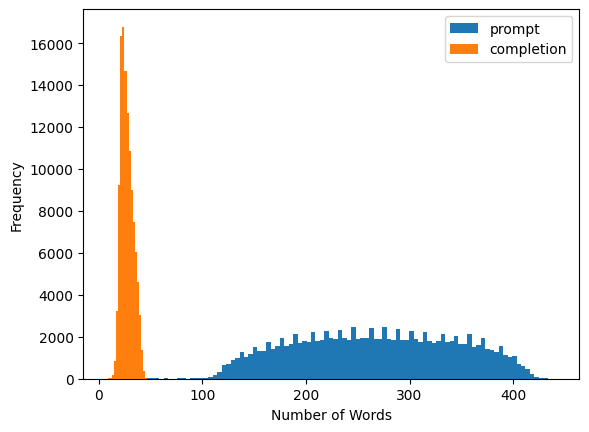

In [17]:
plt.hist(n_words_prompt, bins=100, label="prompt")
plt.hist(n_words_completion, bins = 20, label = "completion")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

## Scatter Matrix between prompt, completion and title

Text(0.5, 0.98, 'Pairwise Comparison of Word Counts')

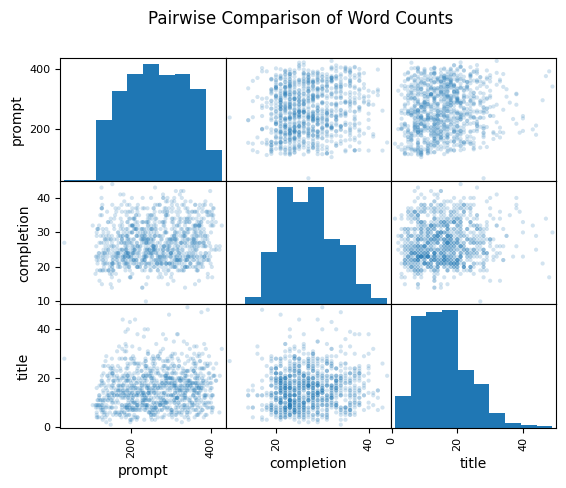

In [18]:
_ = pd.plotting.scatter_matrix(counts.sample(1000), alpha=0.2)
plt.suptitle("Pairwise Comparison of Word Counts")

In [19]:
# correlation?
print(scipy.stats.linregress(n_words_prompt, n_words_completion))
print()
print(scipy.stats.linregress(n_words_prompt, n_words_title))
print()
print(scipy.stats.linregress(n_words_title, n_words_completion))

LinregressResult(slope=np.float64(0.009730547772109977), intercept=np.float64(24.429398166892913), rvalue=np.float64(0.12825565218894822), pvalue=np.float64(0.0), stderr=np.float64(0.00022023506420592166), intercept_stderr=np.float64(0.06111226400406934))

LinregressResult(slope=np.float64(0.01007863606800162), intercept=np.float64(13.100473469969714), rvalue=np.float64(0.1003585668082715), pvalue=np.float64(6.267295155289465e-259), stderr=np.float64(0.00029246675883452247), intercept_stderr=np.float64(0.08115558638563623))

LinregressResult(slope=np.float64(0.07443448768270902), intercept=np.float64(25.846643609629673), rvalue=np.float64(0.09852824352011456), pvalue=np.float64(1.3293605950284917e-249), stderr=np.float64(0.0022005057079933455), intercept_stderr=np.float64(0.038743196977776354))


## Conclusions till now

Any of the Pairs are not co-related, No of Words in the Post, TL;DR and the Title of the Reddit Post

# Understanding more with Evalution Score

We will now be using the Evalution Metrics (Rouge-1 and Rouge-L) to understand more about the TL;DR and the Post based on the results, we are not using it for evalation.

In [27]:
from rouge_score import rouge_scorer
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import torch

In [28]:
train_set_samples = train_set.sample(1000)
train_set_samples.columns, train_set_samples.shape

(Index(['prompt', 'completion', 'prompt_post', 'prompt_title'], dtype='object'),
 (1000, 4))

In [29]:
record = train_set_samples.sample(random_state=56)
print(record.prompt.values[0])
print("-------------------------------")
print(record.completion.values[0])

SUBREDDIT: r/relationships

TITLE: My ex cheated on me and now I can't date other people [19F, 20M]

POST: I [19F] recently got out of a terrible relationship with my ex [20M]. We dated about six months and I had rearranged my life to be with him - he was moving about 4hrs away, so I bought a car to go visit him, took extra shifts at work to pay for gas, all while going to school full-time. Our relationship was good initially, but after awhile he became verbally abusive towards me, began to stand me up constantly and accused me of cheating on a daily basis. I stupidly put up with this.

I found out that about two months after we got together, he had started cheating on me. I am aware of 6 other girls. When I confronted him he blamed me for it and said he had never wanted to date me, but I wouldn't sleep with him until I got a commitment so he told me what I wanted to hear. He said I should have expected it, and called me a ton of horrible names.

It was crushing. I've been trying to da

In [30]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scorer.score(record.prompt.values[0], record.completion.values[0])

{'rouge1': Score(precision=0.8846153846153846, recall=0.06515580736543909, fmeasure=0.12137203166226912),
 'rougeL': Score(precision=0.6923076923076923, recall=0.05099150141643059, fmeasure=0.09498680738786279)}

In [31]:
def rouge_score(p, c):
    scores = scorer.score(p, c)
    return pd.Series({
        'rouge1_precision': scores['rouge1'].precision,
        'rougeL_precision': scores['rougeL'].precision,
    })

scores_df = train_set_samples[["prompt", "completion"]].apply(
    lambda x: rouge_score(x.iloc[0], x.iloc[1]),
    axis=1
)

## ROUGE-1 Precision Score
---
We are using ROUGE-1 Precision Score to understand the overlap of words between the TL;DR and the Reddit Post

it measures unigram overlap between a Reddit Post and the TL;DR w.r.t to the TL;DR of the Post

$$
\text{Rouge1 - Precision} = \frac{\text{Overlapping Unigrams b/w Post and TL;DR}}{\text{Total Unigrams in TL;DR}}
$$


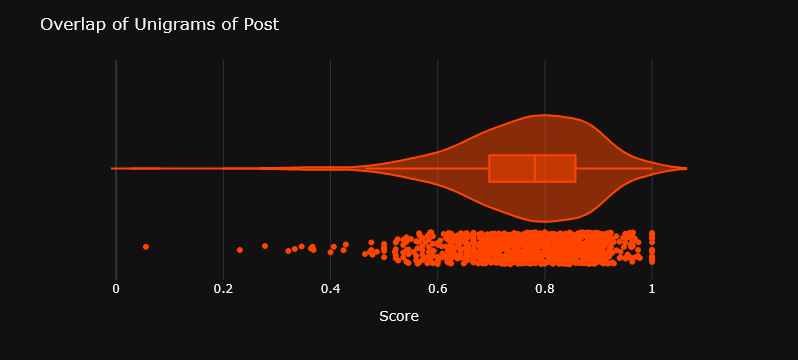

In [32]:
fig = px.violin(x=scores_df["rouge1_precision"], points="all", box=True, color_discrete_sequence=["orangered"])
fig.update_layout(
    barmode='overlay',
    title='Overlap of Unigrams of Post',
    xaxis_title='Score',
    template='plotly_dark'
)

## Conclusion based on the Rouge Unigram Score's Precision
---
We can see most of the words in the tl;dr are also present in the prompt.That is the TL;DR is mostly referring from the prompt, but includes some words which were not from the prompt.

**so Next question are they directly extracting the words in same order ?**

## ROUGE-L Precision Score
---
We are planning to use this score to see the common and longest LCS in the TL;DR and Post.

ROUGE-L measures the longest common subsequence (LCS) between a prompt and the TL;DR.

$$
\text{Precision} = \frac{\text{Length of LCS}(X, Y)}{\text{Length of TL;DR string}}
$$


### LCS:
---
Here, $\text{LCS}(X, Y)$ is the length of the longest common subsequence between the reference $X$ and the candidate $Y$.

**Sentence 1:** "The quick brown fox jumps over the lazy dog"  
**Sentence 2:** "The slow red cat jumps over the lazy bear"  

__LCS:__ The jumps over the lazy

so Precision of LCS(1, 2) = 5/9


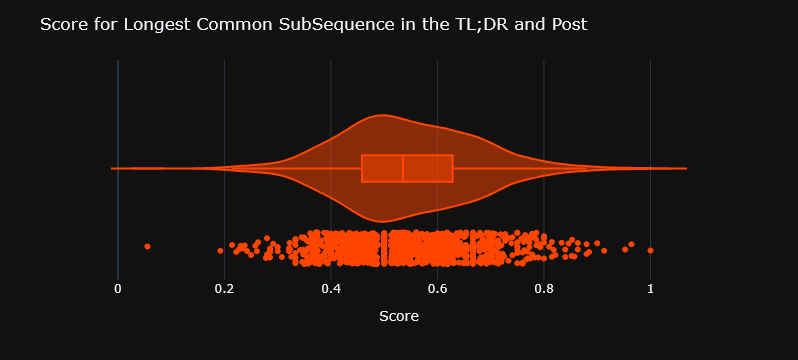

In [33]:
fig = px.violin(x=scores_df["rougeL_precision"], points="all", box=True, color_discrete_sequence=["orangered"])
fig.update_layout(
    barmode='overlay',
    title='Score for Longest Common SubSequence in the TL;DR and Post',
    xaxis_title='Score',
    template='plotly_dark'
)

fig.show()

## Conclusion based on the RougeL_Precision
---

though the TL;DR seems to have most of the words coming from the prompt but it does not seem to be copying specific part of the sequence of the prompt only (which is expected from good sumarizer) so it is generating TL;DR of the post though it uses most of the words from the prompt but the ordering and paraphrasing is not copied exactly.

## Conclusion

since the prompts and completion are ~60% same which means the TL;DR is abstractive and not exactly that of the prompt.